<a href="https://colab.research.google.com/github/big-data-project-drffw/bd-weather-prev/blob/main/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [91]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import Normalizer
from scipy.signal import savgol_filter
from google.colab import drive
from google.colab import files
from string import ascii_letters
import seaborn as sns
from datetime import datetime
from scipy.stats import laplace
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Funções de ínicio

In [92]:
def missing_zero_table(df):
    df = df.apply(pd.to_numeric, errors='coerce')

    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)

    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns={0: 'Valores Zero', 1: 'Valores Perdidos', 2: '% de Valores Totais'})

    mz_table['Total Zero Valores Perdidos'] = mz_table['Valores Zero'] + mz_table['Valores Perdidos']
    mz_table['% Total Zero Valores Perdidos'] = 100 * mz_table['Total Zero Valores Perdidos'] / len(df)
    mz_table['Tipo de Dado'] = df.dtypes

    # Filter only columns with missing or zero values
    mz_table = mz_table[
        (mz_table['Valores Perdidos'] != 0) | (mz_table['Valores Zero'] != 0)
    ].sort_values('% de Valores Totais', ascending=False).round(2)

    print(f"O Dataframe selecionado tem {df.shape[1]} colunas e {df.shape[0]} linhas.\n"
          f"Dessas, {mz_table.shape[0]} colunas possuem valores perdidos ou zero.")

    return mz_table

def convert_cols_to_numeric(df):
  converted_df = df.copy()
  for col in converted_df.columns:
    if converted_df[col].dtype == 'object':  # Check if the column is of type 'object'
        try:
            # Attempt to convert to numeric, handling errors by coercing to NaN
            converted_df[col] = pd.to_numeric(converted_df[col], errors='coerce')
        except ValueError:
            # Handle cases where conversion fails (e.g., non-numeric strings)
            print(f"Could not convert column '{col}' to numeric. Skipping...")
  return converted_df


# Lendo Estação A (Igarassu)

In [93]:
g1 = pd.read_csv("https://raw.githubusercontent.com/big-data-project-drffw/bd-weather-prev/0251f6b8fdee4aab565cbd460fbafc6abc349db5/data1.csv",
                 sep=';',
                 index_col='Data Medicao',
                 date_format=(lambda t:pd.to_datetime(str(t),format='%d/%m/%Y', dayfirst = True)),
                 header=0)
g1.drop(g1.columns[-1], axis=1, inplace=True)
g1.head()

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
Data Medicao,,,,,,,,,,
2019-01-01,0,"923,5","17,7","30,6","23,1","19,5","74,3",41.0,"15,9","3,8"
2019-01-02,",2","924,3","17,6","29,4","23,3","19,6","73,2",38.0,"11,2","3,5"
2019-01-03,0,"923,2",17,"29,6","22,8","18,4","72,8",38.0,"9,5",3
2019-01-04,0,"923,5","17,2","30,1","23,1","19,1","72,1",42.0,"7,6","2,2"
2019-01-05,0,"923,1","17,6","25,9","22,1","19,3","76,8",54.0,"9,1","2,8"


# Lendo Estação B (Caruaru)

In [94]:
g2 = pd.read_csv("https://raw.githubusercontent.com/big-data-project-drffw/bd-weather-prev/refs/heads/main/data2.csv",
                 sep=';',
                 index_col='Data Medicao',
                 date_format=(lambda t:pd.to_datetime(str(t),format='%d/%m/%Y', dayfirst = True)),
                 header=0)

g2.drop(g2.columns[-1], axis=1, inplace=True)
g2.head()

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
Data Medicao,,,,,,,,,,
2019-01-01,0,"921,7","18,4","29,3","21,6","18,8","83,1",47.0,13,"3,3"
2019-01-02,",2","922,4",18,"28,3","22,1","19,6","78,7",44.0,"10,6","3,5"
2019-01-03,0,"921,4","17,2","29,4",22,"18,3","77,3",41.0,"9,8",3
2019-01-04,",2","921,7","17,3","28,5","22,1","18,1","76,9",46.0,"9,4",3
2019-01-05,0,"921,2","18,2","27,4","21,8",19,"81,6",54.0,"11,3",3


# Tabelas Números Pedidos A e B

In [95]:
missing_zero_table(g1)
missing_zero_table(g2)

O Dataframe selecionado tem 10 colunas e 1827 linhas.
Dessas, 10 colunas possuem valores perdidos ou zero.
O Dataframe selecionado tem 10 colunas e 1827 linhas.
Dessas, 10 colunas possuem valores perdidos ou zero.


,Valores Zero,Valores Perdidos,% de Valores Totais,Total Zero Valores Perdidos,% Total Zero Valores Perdidos,Tipo de Dado
PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),0,1735,94.96,1735,94.96,float64
"VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",0,1725,94.42,1725,94.42,float64
"TEMPERATURA MEDIA, DIARIA (AUT)(°C)",0,1723,94.31,1723,94.31,float64
TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),0,1715,93.87,1715,93.87,float64
"TEMPERATURA MINIMA, DIARIA (AUT)(°C)",0,1707,93.43,1707,93.43,float64
"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)",0,1706,93.38,1706,93.38,float64
"UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)",0,1700,93.05,1700,93.05,float64
"VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)",0,1686,92.28,1686,92.28,float64
"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",477,1281,70.11,1758,96.22,float64
"UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)",0,700,38.31,700,38.31,float64


# Agrupando Tabelas (Dia)

In [97]:
grouped_g1 = convert_cols_to_numeric(grouped_g1).groupby(g1.index).mean()
grouped_g2 = convert_cols_to_numeric(grouped_g2).groupby(g2.index).mean()
display(grouped_g1, grouped_g2)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Unnamed: 11
Data Medicao,,,,,,,,,,,
2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN
2019-01-03,0.0,NaN,17.0,NaN,NaN,NaN,NaN,38.0,NaN,3.0,NaN
2019-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN
2019-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,NaN,NaN,NaN,NaN,24.0,NaN,NaN,46.0,NaN,NaN,NaN
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,9.0,NaN,NaN
2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN


,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Unnamed: 11
Data Medicao,,,,,,,,,,,
2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,47.0,13.0,NaN,NaN
2019-01-02,NaN,NaN,18.0,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN
2019-01-03,0.0,NaN,NaN,NaN,22.0,NaN,NaN,41.0,NaN,3.0,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,3.0,NaN
2019-01-05,0.0,NaN,NaN,NaN,NaN,19.0,NaN,54.0,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,NaN
2023-12-29,0.0,NaN,NaN,NaN,NaN,19.0,NaN,44.0,NaN,NaN,NaN
2023-12-30,0.0,NaN,NaN,32.0,NaN,NaN,NaN,31.0,NaN,NaN,NaN


# Mesclando tabelas

In [98]:
g3 = grouped_g1.combine_first(grouped_g2)
display(g3)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Unnamed: 11
Data Medicao,,,,,,,,,,,
2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,13.0,NaN,NaN
2019-01-02,NaN,NaN,18.0,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN
2019-01-03,0.0,NaN,17.0,NaN,22.0,NaN,NaN,38.0,NaN,3.0,NaN
2019-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,3.0,NaN
2019-01-05,0.0,NaN,NaN,NaN,NaN,19.0,NaN,54.0,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,0.0,NaN,NaN,NaN,24.0,NaN,NaN,46.0,NaN,NaN,NaN
2023-12-29,0.0,NaN,NaN,NaN,NaN,19.0,NaN,45.0,9.0,NaN,NaN
2023-12-30,0.0,NaN,NaN,32.0,NaN,NaN,NaN,33.0,NaN,NaN,NaN


# Inserir dados faltantes

In [99]:
g3.index = pd.to_datetime(g3.index)

interpolated_g3 = g3.interpolate(method='time')

display(interpolated_g3)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)","VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Unnamed: 11
Data Medicao,,,,,,,,,,,
2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,13.0,NaN,NaN
2019-01-02,0.0,NaN,18.000000,NaN,NaN,NaN,NaN,38.0,12.6,NaN,NaN
2019-01-03,0.0,NaN,17.000000,NaN,22.000000,NaN,NaN,38.0,12.2,3.0,NaN
2019-01-04,0.0,NaN,17.142857,NaN,21.750000,NaN,NaN,42.0,11.8,3.0,NaN
2019-01-05,0.0,NaN,17.285714,NaN,21.500000,19.000000,NaN,54.0,11.4,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,0.0,918.0,20.000000,31.666667,24.000000,18.916667,86.0,46.0,9.0,2.0,NaN
2023-12-29,0.0,918.0,20.000000,31.833333,23.666667,19.000000,86.0,45.0,9.0,2.0,NaN
2023-12-30,0.0,918.0,20.000000,32.000000,23.333333,19.666667,86.0,33.0,10.5,2.0,NaN


# Limpeza (NaN)

In [103]:
interpolated_g3.drop(interpolated_g3.columns[-1], axis=1, inplace=True)

dcorr1 = interpolated_g3.dropna()

display(dcorr1)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)"
Data Medicao,,,,,,,,
2019-01-09,0.0,920.500000,17.857143,27.000000,21.250000,19.000000,85.1875,51.0
2019-01-10,0.0,920.333333,18.000000,27.400000,21.375000,19.000000,85.2500,47.0
2019-01-11,0.0,920.166667,18.000000,27.800000,21.500000,19.000000,85.3125,41.0
2019-01-12,0.0,920.000000,18.000000,28.200000,21.625000,19.000000,85.3750,35.0
2019-01-13,0.0,921.500000,18.000000,28.600000,21.750000,19.000000,85.4375,48.0
...,...,...,...,...,...,...,...,...
2023-12-28,0.0,918.000000,20.000000,31.666667,24.000000,18.916667,86.0000,46.0
2023-12-29,0.0,918.000000,20.000000,31.833333,23.666667,19.000000,86.0000,45.0
2023-12-30,0.0,918.000000,20.000000,32.000000,23.333333,19.666667,86.0000,33.0


<Figure size 1000x1000 with 0 Axes>

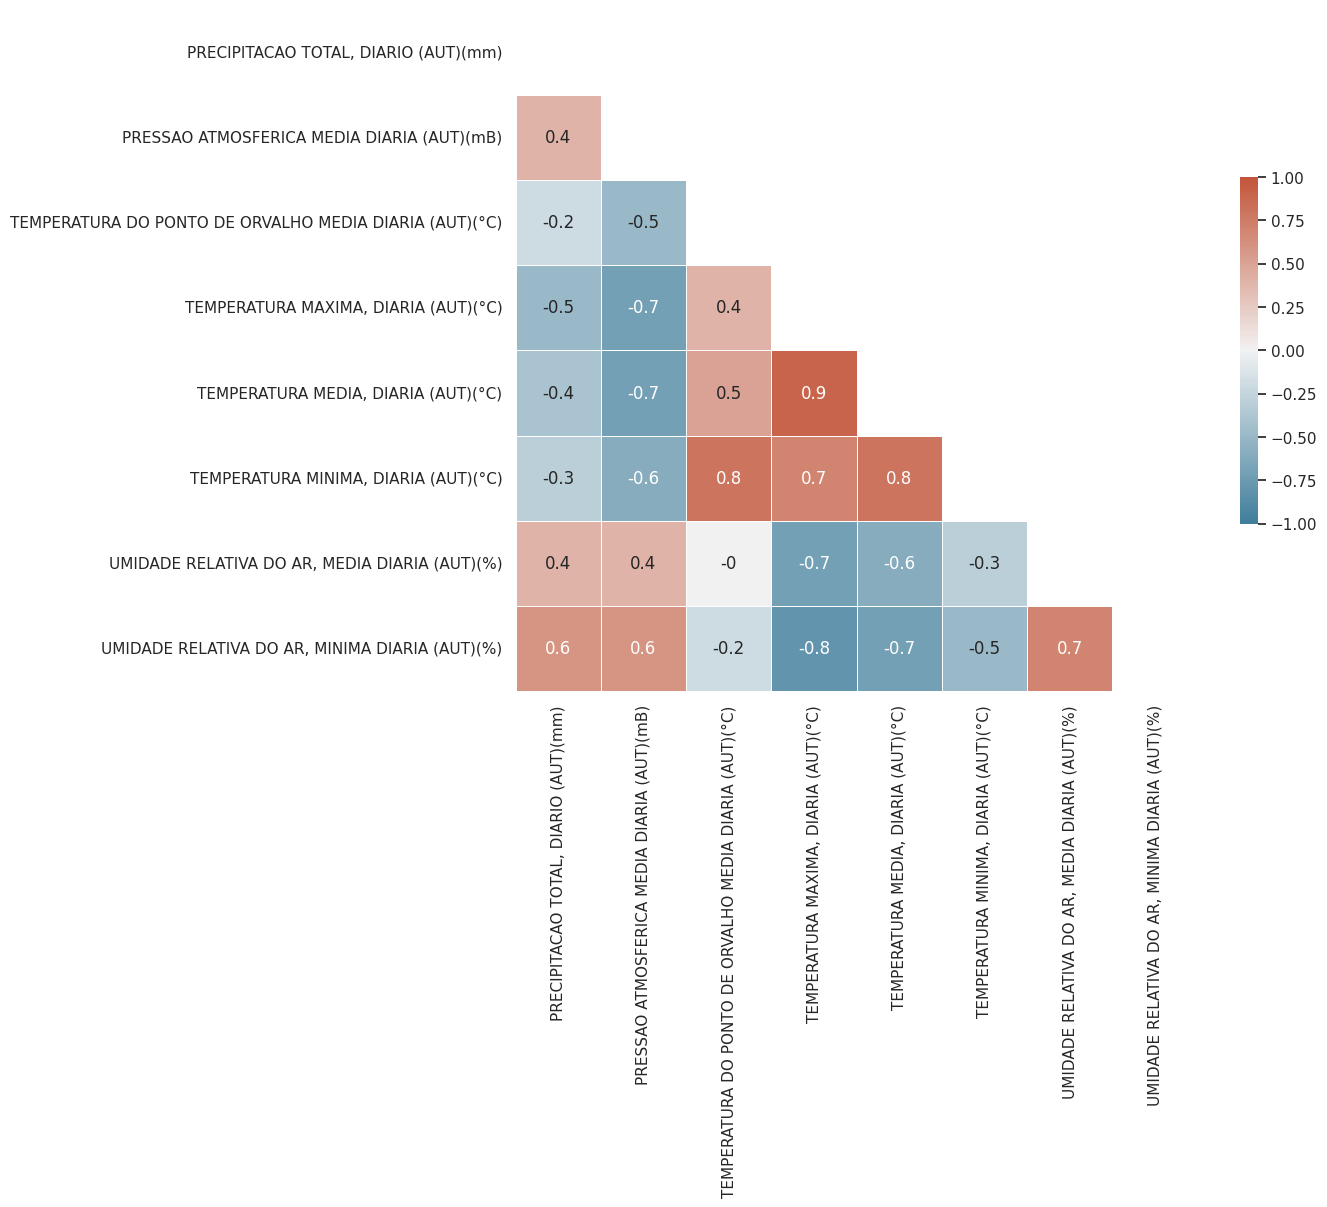

<Figure size 1000x1000 with 0 Axes>

In [109]:
#Tema
sns.set_theme(style="white")

# Cálculo da Correlação
corr1 = dcorr1.corr().round(1)

# Mascára cobre metade do quadrado.
mask = np.triu(np.ones_like(corr1, dtype=bool))

# Tamanho do Mapa
f, ax = plt.subplots(figsize=(11, 9))

# Cor customizada do Mapa
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenhar o mapa
fig1 = sns.heatmap(corr1, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.figure(figsize=(10,10))

# Dados de Correlação

In [105]:
display(corr1)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","TEMPERATURA MINIMA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)"
"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)",1.0,0.4,-0.2,-0.5,-0.4,-0.3,0.4,0.6
PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),0.4,1.0,-0.5,-0.7,-0.7,-0.6,0.4,0.6
TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C),-0.2,-0.5,1.0,0.4,0.5,0.8,-0.0,-0.2
"TEMPERATURA MAXIMA, DIARIA (AUT)(°C)",-0.5,-0.7,0.4,1.0,0.9,0.7,-0.7,-0.8
"TEMPERATURA MEDIA, DIARIA (AUT)(°C)",-0.4,-0.7,0.5,0.9,1.0,0.8,-0.6,-0.7
"TEMPERATURA MINIMA, DIARIA (AUT)(°C)",-0.3,-0.6,0.8,0.7,0.8,1.0,-0.3,-0.5
"UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)",0.4,0.4,-0.0,-0.7,-0.6,-0.3,1.0,0.7
"UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)",0.6,0.6,-0.2,-0.8,-0.7,-0.5,0.7,1.0
